In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("../data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


Посмотрим на датасет:

* artist name: имя артиста
* track name: название трека
* popularity: популятрость трека до 100
* danceability: танцевальный трек или нет
* energy: энергичный трек или нет
* key: ключевой компонент трека
* loudness: громкость трека
* mode: режим движения трека
* speechiness: показывает присутствуют ли слова в треке
* acousticness: показывает насколько акустическим является трек; 1.0 означает, что трек акустический
* instrumentalness: показывает количество вокала в треке; 1.0 означает, что трек инструментальный
* liveness: показывает вероятность того, что трек был записан с живой аудиторией
* valence: принимает значение от 0.0 до 1.0, описывающая музыкальный позитив, передаваемый треком.
* tempo: темп трека
* duration_in min/ms: время трека
* time_signature: временная сигнатура
* class: жанр (класс)

Посмотрим на тип данных:

In [3]:
data.dtypes

Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object

Посмотрим, есть ли в данных дубликаты:

In [4]:
duplicate_rows = data[data.duplicated()]
print("Количество строк-дубликатов: ", duplicate_rows.shape[0])

Количество строк-дубликатов:  0


Посмотрим на классы:

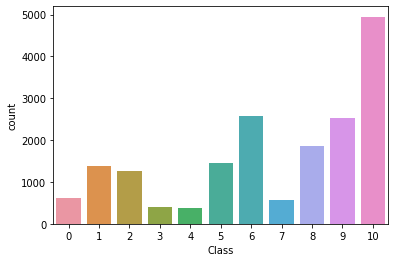

In [5]:
sns.countplot(data=data, x='Class')
plt.show()

Теперь поработаем с колнкой duration_in min/ms. Хочется сделать ее колонкой duration_in ms, поэтому для всех значений меньше 30 умножим на 60_000:

In [6]:
data.loc[(data['duration_in min/ms'] < 30)]['duration_in min/ms']

7        3.105783
10       4.330450
13       4.440250
25       4.015633
34       3.503783
           ...   
17952    5.407783
17959    3.686017
17974    3.408667
17986    4.392883
17988    3.787783
Name: duration_in min/ms, Length: 2580, dtype: float64

In [7]:
changes = data['duration_in min/ms'] < 30 
data.loc[changes,'duration_in min/ms'] = data.loc[changes,'duration_in min/ms']*60000

И после этого переименуем колонку)

In [8]:
data.rename(columns={"duration_in min/ms": "duration_in_ms"}, inplace=True)

В данных есть пропущенные значения:

In [9]:
data.isna().sum()

Artist Name            0
Track Name             0
Popularity           428
danceability           0
energy                 0
key                 2014
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness    4377
liveness               0
valence                0
tempo                  0
duration_in_ms         0
time_signature         0
Class                  0
dtype: int64

In [10]:
data.shape

(17996, 17)

Колонки, содержащие Nan значения:
* Popularity
* key
* instrumentalness

Посмотрим распределенение:

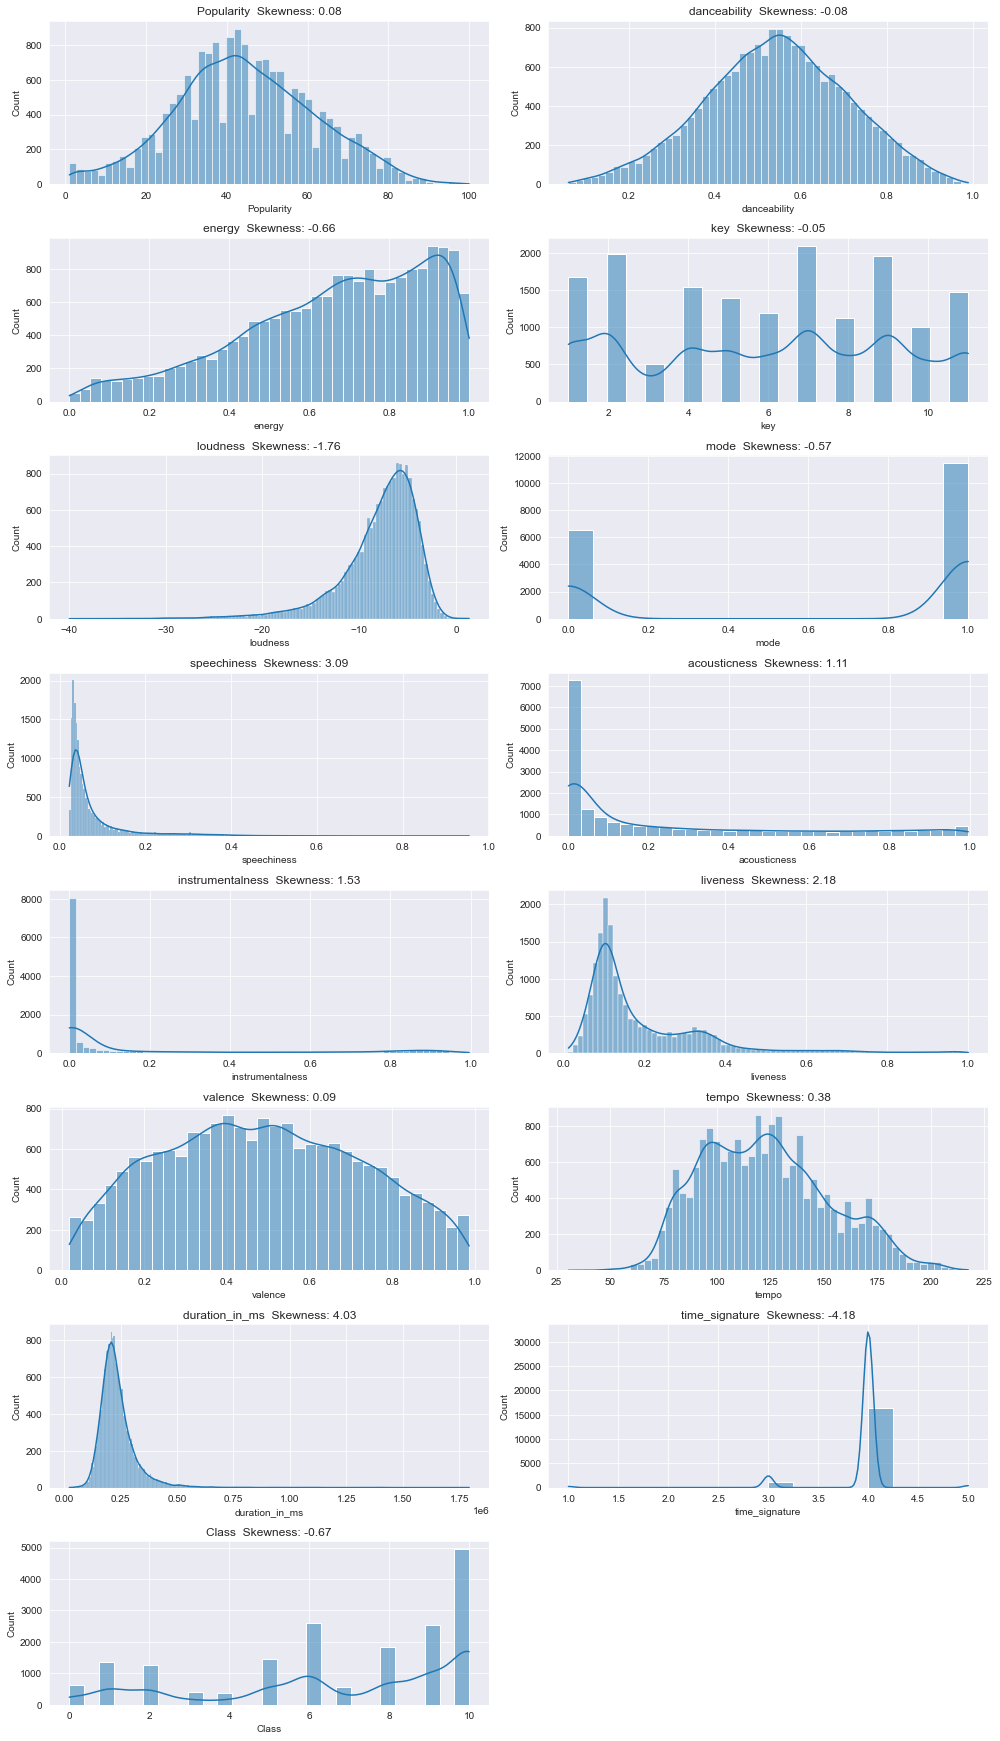

In [11]:
sns.set_style("darkgrid")
 
numerical_columns = data.select_dtypes(include=["int64", "float64"]).columns
 
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(data[feature], kde=True)
    plt.title(f"{feature}  Skewness: {round(data[feature].skew(), 2)}")
plt.tight_layout()
plt.show()

Посмотрим на графики: 
* Popularity нормально распределены, используем среднее для того чтобы заполнить NaN
* Key тоже более менее нормально распределен, используем среднее для того чтобы заполнить NaN 
* instrumentalness положительно ассиметричен, так что заполнять пропущенные значения будем медианой


Теперь сделаем это:

In [12]:
data['Popularity'].fillna(data['Popularity'].mean(), inplace=True)
data['key'].fillna(data['key'].mean(), inplace=True)
data['instrumentalness'].fillna(data['instrumentalness'].median(), inplace=True)

In [13]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in_ms,time_signature,Class
count,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.135326,0.196170,0.486208,122.623294,2.358233e+05,3.924039,6.695821
std,17.218436,0.166268,0.235373,3.012651,4.049151,0.480949,0.083576,0.310632,0.274791,0.159212,0.240195,29.571527,8.567503e+04,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,2.332000e+04,1.000000,0.000000
25%,33.000000,0.432000,0.509000,4.000000,-9.538000,0.000000,0.034800,0.004300,0.000294,0.097500,0.297000,99.620750,1.876497e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,5.952447,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.200000e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,8.000000,-5.189000,1.000000,0.083000,0.434000,0.056600,0.258000,0.672000,141.969250,2.630822e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.793160e+06,5.000000,10.000000


Глядя на графики и на таблицу выше, заключим что следующие переменные распределены ненормально:


* loudness
* speechiness
* acousticness
* instrumentalness
* liveness
* duration_in_ms



Проверим подозрительные колонки (key, mode, time_signature, Class) на уникальныe значения, кажется они категориальные, когда будем преобрабатывать данные, учтем

In [14]:
for i in ['key', 'mode', 'time_signature', 'Class']:
    print(f'Unique recordings in {i} column: {data[i].unique()}')

Unique recordings in key column: [ 1.         3.         6.        10.         2.         5.
  7.         9.        11.         8.         5.9524465  4.       ]
Unique recordings in mode column: [1 0]
Unique recordings in time_signature column: [4 3 1 5]
Unique recordings in Class column: [ 5 10  6  2  4  8  9  3  7  1  0]


Посмотрим на выбросы:

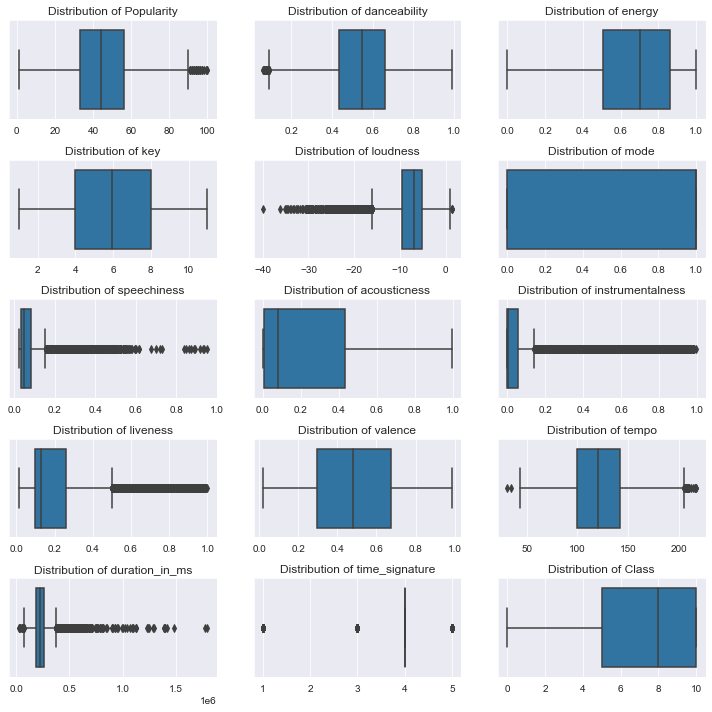

In [15]:
data_cont = data.select_dtypes(include=["int64", "float64"])

fig = plt.figure(figsize=(10, 10)) 
for i, columns in enumerate(data_cont.columns, 1):
    ax = plt.subplot(5,3,i) 
    sns.boxplot(data = data_cont, x=data_cont[columns]) 
    ax.set_xlabel(None) 
    ax.set_title(f'Distribution of {columns}') 
    plt.tight_layout(w_pad=3) 
plt.show()

И посмотрим на корреляцию при помощи heatmap

<AxesSubplot:>

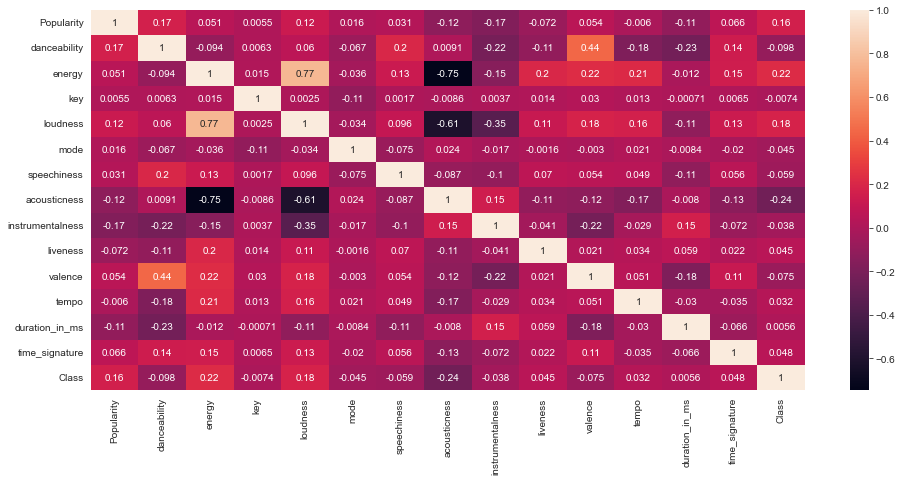

In [16]:
plt.figure(figsize=(16, 7))
sns.heatmap(data.corr(), annot = True)

Итак, переменные energy и loudness имеют сильную положительную корреляцию 0.77, а переменные energy и acousticness сильную отрицательную корреляцию -0.75. 
Уберем по одной переменной из пары.
Здесь же удалим колонки Artist Name и Track Name, поскольку большинство имеют уникальные значения.

In [17]:
df = data.drop(['energy', 'Artist Name','Track Name'], axis=1)

<AxesSubplot:>

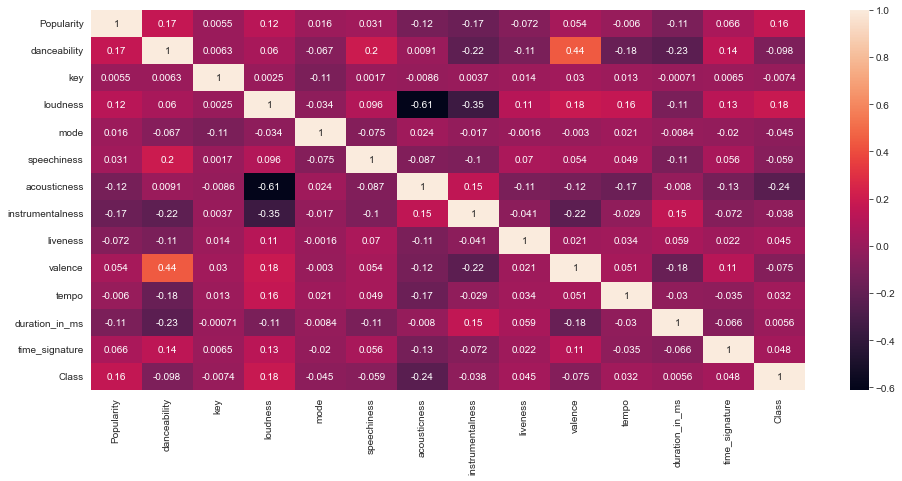

In [18]:
plt.figure(figsize=(16, 7))
sns.heatmap(df.corr(), annot = True)

Проверим данные на наличие нулевых значений:

In [19]:
df.isnull().sum()

Popularity          0
danceability        0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_in_ms      0
time_signature      0
Class               0
dtype: int64

Так как все хорошо, будем считать eda завершенным.

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [20]:
X = df.drop('Class',axis=1)
y = df[['Class']]

In [21]:
cat_cols = ['key', 'mode', 'time_signature']
num_cols = ['Popularity', 'danceability', 'loudness', 'acousticness', 'speechiness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 
            'duration_in_ms']
all_features = cat_cols + num_cols

target = y.values

X = df[all_features]
y = target

In [22]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

In [23]:
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['Popularity',
   'danceability',
   'loudness',
   'acousticness',
   'speechiness',
   'instrumentalness',
   'liveness',
   'valence',
   'tempo',
   'duration_in_ms']),
 ('ohe', OneHotEncoder(), ['key', 'mode', 'time_signature'])]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [25]:
from sklearn.pipeline import Pipeline
tree_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("tree_pipeline", DecisionTreeClassifier())
])
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Popularity', 'danceability',
                                                   'loudness', 'acousticness',
                                                   'speechiness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_in_ms']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['key', 'mode',
                                                   'time_signature'])])),
                ('tree_pipeline', DecisionTreeClassifier())])

In [26]:
y_pred = tree_pipeline.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred)

0.31472222222222224

Теперь попробуем использовать GridSearchCV для подбора параметров:

In [28]:
n_features = X.shape[1]
n_samples = X.shape[0]
print(n_samples)

grid = GridSearchCV(DecisionTreeClassifier(random_state=1), cv=3, n_jobs=-1, verbose=5,
                    param_grid ={
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15],
                    'max_features': [None, 'sqrt', 'auto', 'log2', 0.3, 0.5, 0.7, n_features//2, n_features//3, ],
                    'min_samples_split': [2, 0.3, 0.5, 10, 20, n_samples//2, n_samples//3, n_samples//5],
                    'min_samples_leaf':[1, 0.3, 0.5, 3, 5, 10, 15, 20, n_samples//2, n_samples//3, n_samples//5]},
                    )

grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

17996
Fitting 3 folds for each of 17424 candidates, totalling 52272 fits
Train Accuracy : 0.450
Test Accuracy : 0.420
Best Score Through Grid Search : 0.432
Best Parameters :  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 0.7, 'min_samples_leaf': 20, 'min_samples_split': 2}


In [29]:
cross_val_results = pd.DataFrame(grid.cv_results_)
print('Number of Various Combinations of Parameters Tried : %d'%len(cross_val_results))

cross_val_results.head() 

Number of Various Combinations of Parameters Tried : 17424


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.266929,0.006952,0.005717,0.001285,gini,None,None,1,2,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.319233,0.314441,0.317632,0.317102,0.001992,5405
1,0.069268,0.005621,0.004818,0.000615,gini,None,None,1,0.3,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.376954,0.355491,0.370988,0.367811,0.009046,2161
2,0.055263,0.002376,0.003864,0.000210,gini,None,None,1,0.5,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.345489,0.313190,0.342434,0.333704,0.014559,3881
3,0.259550,0.001312,0.005324,0.000569,gini,None,None,1,10,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.326318,0.334445,0.333889,0.331551,0.003707,4328
4,0.241151,0.009427,0.005176,0.000239,gini,None,None,1,20,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.366951,0.361742,0.364944,0.364546,0.002145,2375


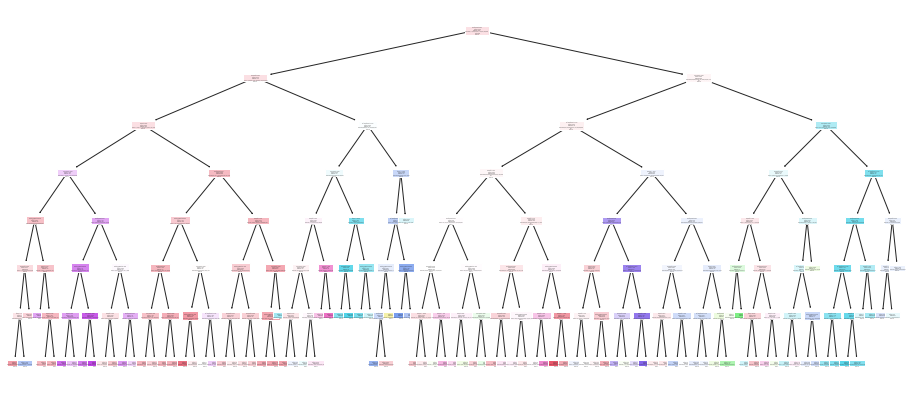

In [30]:
cn = list(df['Class'].unique())
fn = list(X.columns)
cn = [str(v) for v in cn]
plt.figure(figsize=(16, 7))

tree.plot_tree(grid.best_estimator_,
               feature_names=fn,
               class_names=cn,
               filled=True)

plt.show()

И второй способ подбора с меньшим количеством параметров

In [32]:
dtc_params = {
    'criterion': ['entropy', 'gini'],
    'max_depth':[None,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
    'min_samples_leaf':[2,3,4,5,6,7,8,9,10,11,12,15,20]
}
# set the gridsearch
dtc_gs = GridSearchCV(DecisionTreeClassifier(), 
                      dtc_params, 
                      cv=5, 
                      verbose=1, 
                      scoring='accuracy', 
                      n_jobs=-1)

In [33]:
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 546 candidates, totalling 2730 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       15, 20, 30, 40, 50, 70, 90, 120, 150],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 15, 20]},
             scoring='accuracy', verbose=1)

In [34]:
dtc_gs.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 20}

In [35]:
dtc_gs.best_score_

0.42650804677550075

In [36]:
best_dtc = dtc_gs.best_estimator_
y_pred = best_dtc.predict(X_test)

In [37]:
print('accuracy = {}'.format(accuracy_score(y_test, y_pred)))

accuracy = 0.41805555555555557


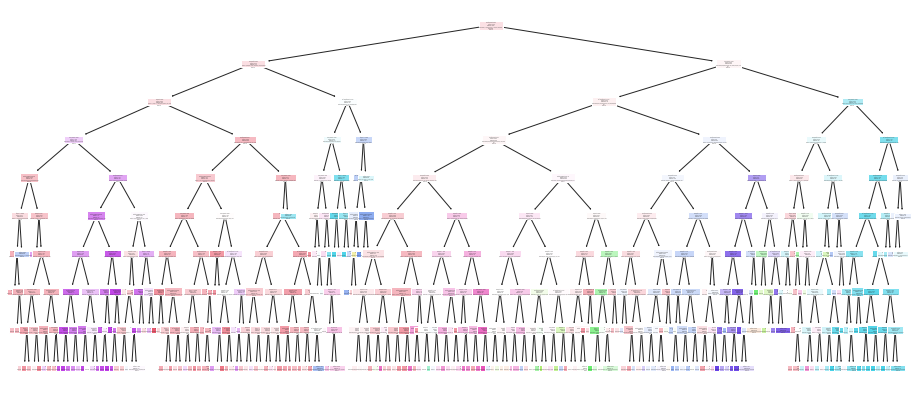

<Figure size 432x288 with 0 Axes>

In [38]:
cn = list(df['Class'].unique())
fn = list(X.columns)
cn = [str(v) for v in cn]
plt.figure(figsize=(16, 7))

tree.plot_tree(best_dtc,
               feature_names=fn,
               class_names=cn,
               filled=True)

plt.show()

 Деревья получились, конечно, страшненькие, но accuracy score все же стал получше

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

Я возьму не другие классификаторы, а этот же, только хочется проделать то же самое, решив дисбаланс классов. Интересно станет ли лучше.



Вернемся к классам. У нас явный дисбаланс, так что по аналогии с прошлым дз, решим эту проблему.

In [39]:
df['Class'].unique()

array([ 5, 10,  6,  2,  4,  8,  9,  3,  7,  1,  0], dtype=int64)

In [40]:
df_5 = df[df['Class'] == 5]
df_10 = df[df['Class'] == 10]
df_6 = df[df['Class'] == 6]
df_2 = df[df['Class'] == 2]
df_4 = df[df['Class'] == 4]
df_8 = df[df['Class'] == 8]
df_9 = df[df['Class'] == 9]
df_3 = df[df['Class'] == 3]
df_7 = df[df['Class'] == 7]
df_1 = df[df['Class'] == 1]
df_0 = df[df['Class'] == 0]

In [41]:
df_5.shape # 1447
#df_10.shape # 4949
#df_6.shape 2587
#df_2.shape # 1272
#df_4.shape # 387
#df_8.shape # 1854
#df_9.shape # 2524
#df_3.shape # 402
#df_7.shape # 576
#df_1.shape # 1373
#df_0.shape # 625

(1447, 14)

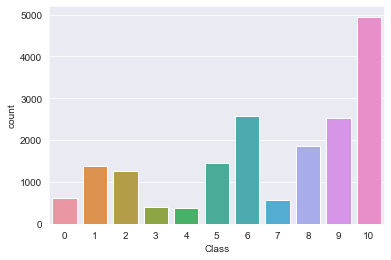

In [42]:
sns.countplot(data=df, x='Class')
plt.show()

Будем приводить все к 8 классу. То есть к 1854.

In [43]:
from sklearn.utils import resample
df_0 = resample(df_0, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_1 = resample(df_1, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_2 = resample(df_2, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_3 = resample(df_3, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_4 = resample(df_4, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_5 = resample(df_5, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_6 = resample(df_6, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_7 = resample(df_7, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_9 = resample(df_9, 
                replace=True,
                n_samples=1854,
                random_state=123)
df_10 = resample(df_10, 
                replace=True,
                n_samples=1854,
                random_state=123)


In [44]:
r_df = pd.concat([df_8, df_0])
r_df = pd.concat([r_df, df_1])
r_df = pd.concat([r_df, df_2])
r_df = pd.concat([r_df, df_3])
r_df = pd.concat([r_df, df_4])
r_df = pd.concat([r_df, df_5])
r_df = pd.concat([r_df, df_6])
r_df = pd.concat([r_df, df_7])
r_df = pd.concat([r_df, df_9])
r_df = pd.concat([r_df, df_10])
r_df.Class.value_counts()

8     1854
0     1854
1     1854
2     1854
3     1854
4     1854
5     1854
6     1854
7     1854
9     1854
10    1854
Name: Class, dtype: int64

In [45]:
X = r_df.drop('Class',axis=1)
y = r_df[['Class']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [46]:
dtc_params = {
    'criterion': ['entropy', 'gini'],
    'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15],
    'min_samples_leaf':[2,3,4,5,6,7,8,9,10,11,12,15,20]
}
# set the gridsearch
dtc_gs = GridSearchCV(DecisionTreeClassifier(), 
                      dtc_params, 
                      cv=5, 
                      verbose=1, 
                      scoring='accuracy', 
                      n_jobs=-1)

In [47]:
dtc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 338 candidates, totalling 1690 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       15],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 15, 20]},
             scoring='accuracy', verbose=1)

In [48]:
dtc_gs.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2}

In [49]:
dtc_gs.best_score_

0.6555930125651241

In [50]:
best_dtc = dtc_gs.best_estimator_
y_pred = best_dtc.predict(X_test)

In [51]:
print('accuracy = {}'.format(accuracy_score(y_test, y_pred)))

accuracy = 0.6788428536405982


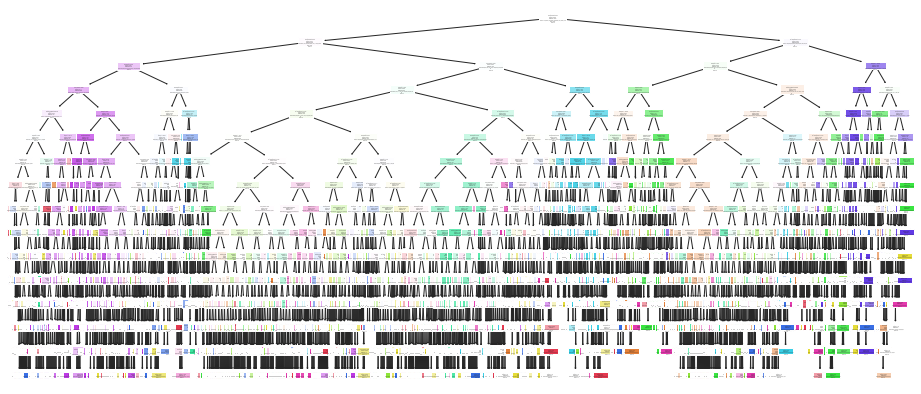

In [52]:
cn = list(df['Class'].unique())
fn = list(X.columns)
cn = [str(v) for v in cn]
plt.figure(figsize=(16, 7))

tree.plot_tree(best_dtc,
               feature_names=fn,
               class_names=cn,
               filled=True)

plt.show()

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Фильм "Опасная игра Слоан" - один из моих любимейших фильмов. Классный сюжетный поворот, что-то вроде детектива, еще и главная героиня - умная (!!!) женщина, которая не тупит. Эх, как вспомнила по него - захотелось пересмотреть)

2. Сериал "Ганнибал" 2013 года. В нем прекрасно все: детектив с щепоткой ужасов, прекрасный каст, есть нелинейная история вместе с общей сюжеткой, происходящие параллельно. Я его смотрю на английском, так как русская озвучка мне не понравилась, так что добавляется еще практика английского))

3. Сериал "След" - один из вечных детективов, сколько ни смотрю с семьей - похожих историй не было. 

![title](../data/meme.jpg)